In [61]:
import json
import os

# Đường dẫn đến thư mục dataset (điều chỉnh nếu cần thiết)
DATASET_DIR = '../../dataset_final'
PARTITIONS = ['train', 'validation', 'test']

print(f"Bắt đầu quy trình gộp file (Merge) tại: {os.path.abspath(DATASET_DIR)}\n")

for partition in PARTITIONS:
    partition_path = os.path.join(DATASET_DIR, partition)
    
    if not os.path.exists(partition_path):
        print(f"⚠️ Không tìm thấy thư mục: {partition_path}")
        continue

    # Định nghĩa đường dẫn file
    manual_path = os.path.join(partition_path, 'manual.json')
    auto_path = os.path.join(partition_path, 'auto.json')
    target_path = os.path.join(partition_path, 'labels.json')
    
    merged_data = []
    count_manual = 0
    count_auto = 0
    
    # 1. Đọc Manual Data (Ưu tiên đưa lên đầu)
    if os.path.exists(manual_path):
        try:
            with open(manual_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if isinstance(data, list):
                    merged_data.extend(data)
                    count_manual = len(data)
        except Exception as e:
            print(f"❌ Lỗi đọc file Manual tại {partition}: {e}")

    # 2. Đọc Auto Data
    if os.path.exists(auto_path):
        try:
            with open(auto_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if isinstance(data, list):
                    merged_data.extend(data)
                    count_auto = len(data)
        except Exception as e:
            print(f"❌ Lỗi đọc file Auto tại {partition}: {e}")
            
    # 3. Ghi ra file labels.json
    if merged_data:
        try:
            with open(target_path, 'w', encoding='utf-8') as f:
                json.dump(merged_data, f, ensure_ascii=False, indent=4)
            
            print(f"✅ [{partition.upper()}] Đã tạo 'labels.json'")
            print(f"   - Manual: {count_manual} mẫu")
            print(f"   - Auto:   {count_auto} mẫu")
            print(f"   => Tổng:  {len(merged_data)} mẫu")
        except Exception as e:
            print(f"❌ Không thể ghi file labels.json tại {partition}: {e}")
    else:
        print(f"⚠️ [{partition.upper()}] Không có dữ liệu để gộp (thiếu cả manual và auto).")

print("\n--- HOÀN TẤT QUÁ TRÌNH GỘP FILE ---")

Bắt đầu quy trình gộp file (Merge) tại: d:\Coding\School\Y3-K1\Intro2DS\DS - LAB 2\Milestone2_Project\dataset_final

✅ [TRAIN] Đã tạo 'labels.json'
   - Manual: 143 mẫu
   - Auto:   8844 mẫu
   => Tổng:  8987 mẫu
✅ [VALIDATION] Đã tạo 'labels.json'
   - Manual: 41 mẫu
   - Auto:   1247 mẫu
   => Tổng:  1288 mẫu
✅ [TEST] Đã tạo 'labels.json'
   - Manual: 30 mẫu
   - Auto:   1240 mẫu
   => Tổng:  1270 mẫu

--- HOÀN TẤT QUÁ TRÌNH GỘP FILE ---


In [62]:
import json
import os
import sys
import pandas as pd
import numpy as np

# Setup path để import src module
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import từ src.ml module
from src.ml import (
    load_dataset_raw,
    deduplicate_list,
    parse_bibtex_fast,
    check_data_quality,
    print_data_quality_report
)

# --- CẤU HÌNH ---
DATASET_DIR = '../../dataset_final'
PARTITIONS = ['train', 'validation', 'test']

print("✅ Import modules thành công!")
print(f"Đang tải và xử lý dữ liệu từ: {os.path.abspath(DATASET_DIR)}\n")

# Load dataset sử dụng hàm từ module
df_all = load_dataset_raw(DATASET_DIR, PARTITIONS)

# Parse BibTeX nhanh để lấy title/author
df_all[['bib_title', 'bib_author']] = df_all['bib_content'].apply(
    lambda x: pd.Series(parse_bibtex_fast(x))
)

print(f"\n--- TỔNG HỢP ---")
print(f"Tổng số mẫu sạch đã load: {len(df_all)}")

# Check nhanh
missing_parse = df_all[df_all['bib_title'] == ''].shape[0]
print(f"Số mẫu không parse được Title: {missing_parse}")

✅ Import modules thành công!
Đang tải và xử lý dữ liệu từ: d:\Coding\School\Y3-K1\Intro2DS\DS - LAB 2\Milestone2_Project\dataset_final


--- TỔNG HỢP ---
Tổng số mẫu sạch đã load: 11542
Số mẫu không parse được Title: 8932


In [63]:
# Import hàm check quality từ module
from src.ml import check_data_quality

def check_data_quality_detailed(df):
    """Kiểm tra chất lượng dữ liệu chi tiết."""
    print("=== BÁO CÁO CHẤT LƯỢNG DỮ LIỆU CHI TIẾT ===")
    
    # 1. Kiểm tra Ground Truth (Labels)
    missing_gt_title = df[df['gt_title'].str.strip() == ''].shape[0]
    print(f"❌ Ground Truth thiếu Title: {missing_gt_title} mẫu")
    
    # Kiểm tra Authors
    empty_gt_authors = df[df['gt_authors'].apply(
        lambda x: len(x) == 0 if isinstance(x, list) else True
    )].shape[0]
    print(f"❌ Ground Truth thiếu Authors: {empty_gt_authors} mẫu")

    # 2. Kiểm tra BibTeX Content
    missing_bib_title = df[df['bib_title'].str.strip() == ''].shape[0]
    missing_bib_author = df[df['bib_author'].str.strip() == ''].shape[0]
    
    print(f"⚠️ Không parse được Title từ BibTeX: {missing_bib_title} mẫu")
    print(f"⚠️ Không parse được Author từ BibTeX: {missing_bib_author} mẫu")
    
    # Check duplicate authors
    def has_duplicate_authors(auth_list):
        if not isinstance(auth_list, list) or len(auth_list) == 0:
            return False
        clean_list = [str(a).strip() for a in auth_list]
        return len(clean_list) != len(set(clean_list))

    duplicate_authors_count = df['gt_authors'].apply(has_duplicate_authors).sum()
    print(f"ℹ️ Số mẫu có tác giả trùng lặp: {duplicate_authors_count}")

    # Hiển thị các dòng bị lỗi
    error_mask = (df['gt_title'].str.strip() == '') | \
                 (df['gt_authors'].apply(lambda x: len(x) == 0)) | \
                 (df['bib_title'].str.strip() == '')
    
    if error_mask.sum() > 0:
        print("\n--- MẪU DỮ LIỆU BỊ THIẾU THÔNG TIN ---")
        display(df[error_mask][['paper_id', 'key', 'gt_title', 'bib_title']].head())
    else:
        print("\n✅ Không có mẫu bị thiếu thông tin nghiêm trọng.")

# Chạy kiểm tra
if 'df_all' in locals():
    check_data_quality_detailed(df_all)
else:
    print("Vui lòng chạy cell load dữ liệu trước.")

=== BÁO CÁO CHẤT LƯỢNG DỮ LIỆU CHI TIẾT ===
❌ Ground Truth thiếu Title: 0 mẫu
❌ Ground Truth thiếu Authors: 0 mẫu
⚠️ Không parse được Title từ BibTeX: 8932 mẫu
⚠️ Không parse được Author từ BibTeX: 8931 mẫu
ℹ️ Số mẫu có tác giả trùng lặp: 0

--- MẪU DỮ LIỆU BỊ THIẾU THÔNG TIN ---


,paper_id,key,gt_title,bib_title
56,2403-02386,ref_0,Observation of Gravitational Waves from a Bina...,
57,2403-02386,ref_3,The first gravitational-wave source from the i...,
58,2403-02386,ref_4,MOCCA-SURVEY Database - I. Coalescing binary b...,
59,2403-02386,ref_5,Post-Newtonian Dynamics in Dense Star Clusters...,
60,2403-02386,ref_6,Did LIGO Detect Dark Matter?,


# 4. NLP Pipeline EDA: Deep Dive into Text Quality

Phân tích này giúp định hướng cho bước Data Cleaning và Feature Engineering.
Chúng ta sẽ kiểm tra:
1. **Phân bố độ dài (Length Distribution):** So sánh độ dài chuỗi BibTeX vs Ground Truth.
2. **Phân tích nhiễu (Noise Analysis):** Đếm các ký tự đặc biệt của LaTeX còn sót lại.
3. **Baseline Similarity:** Đo lường độ tương đồng tự nhiên giữa các cặp đúng.


C:\Users\duyla\AppData\Local\Temp\ipykernel_33400\48153437.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_eda['latex_noise'], ax=axes[1, 0], palette="viridis")


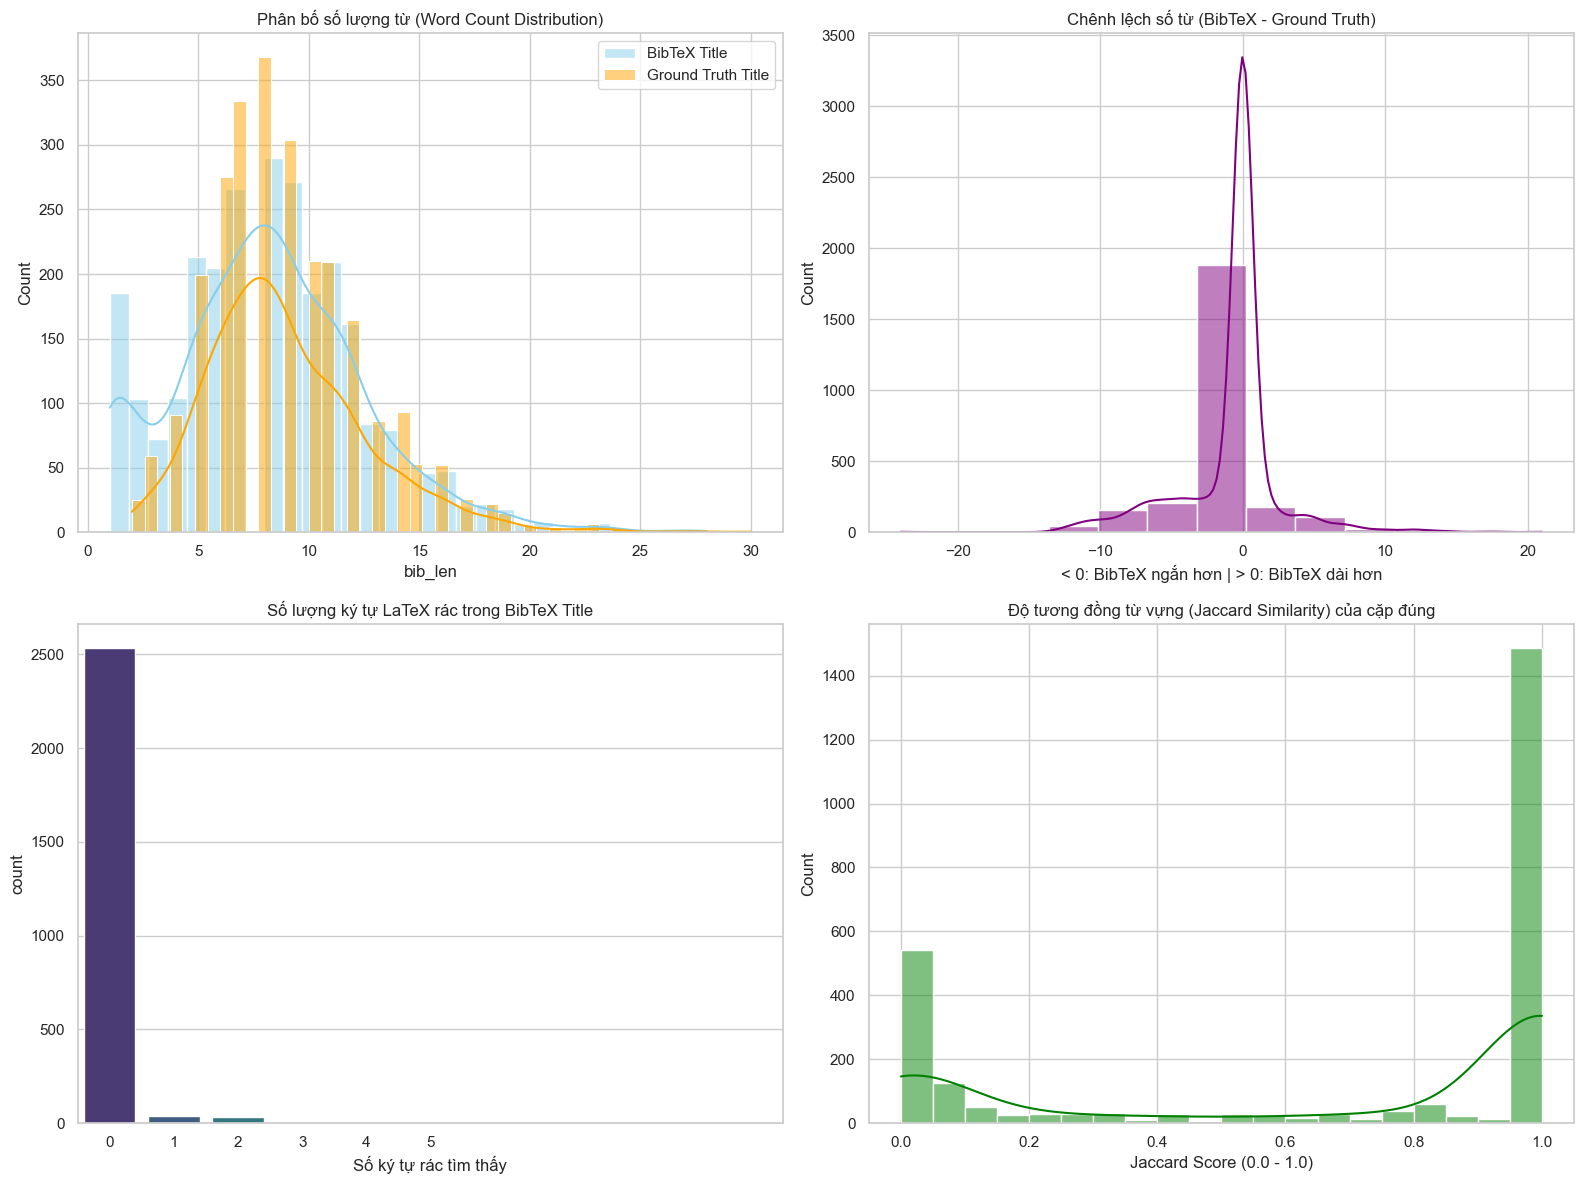


=== NLP EDA SUMMARY REPORT ===
1. Độ dài trung bình (từ): BibTeX = 8.2 | Ground Truth = 9.0
2. Số mẫu bị nhiễm mã LaTeX (>0 ký tự rác): 78 (3.0%)
3. Jaccard Similarity trung bình: 0.663

--- TOP 3 MẪU CÓ TITLE BIBTEX QUÁ NGẮN SO VỚI THỰC TẾ (Có thể do lỗi Parse) ---
BibTeX: The MALATANG Survey: The L $_GAS
Real:   The MALATANG Survey: The LGAS–LIR Correlation on Sub-kiloparsec Scale in Six Nearby Star-forming Galaxies as Traced by HCN J = 4 → 3 and HCO+ J = 4 → 3
------------------------------
BibTeX: AAAI-2024
Real:   A Comprehensive Analysis of the Effectiveness of Large Language Models as Automatic Dialogue Evaluators
------------------------------
BibTeX: RecSys
Real:   TALLRec: An Effective and Efficient Tuning Framework to Align Large Language Model with Recommendation
------------------------------


In [64]:

# %%
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter

# Cấu hình hiển thị
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (14, 10)

# Lấy dữ liệu sạch để phân tích
# Lưu ý: Chỉ phân tích trên tập dữ liệu đã parse thành công title
df_eda = df_all[df_all['bib_title'].str.len() > 0].copy()

# --- 1. PHÂN TÍCH ĐỘ DÀI (LENGTH DISTRIBUTION) ---
# Tại sao quan trọng? Nếu BibTeX Title luôn ngắn hơn GT Title, có thể regex parse bị lỗi cắt chuỗi.

# Tính độ dài số từ (Word Count)
df_eda['bib_len'] = df_eda['bib_title'].apply(lambda x: len(str(x).split()))
df_eda['gt_len'] = df_eda['gt_title'].apply(lambda x: len(str(x).split()))

# Tính sự chênh lệch độ dài
df_eda['len_diff'] = df_eda['bib_len'] - df_eda['gt_len']

# Vẽ biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Biểu đồ 1: Phân bố số từ
sns.histplot(df_eda['bib_len'], color='skyblue', label='BibTeX Title', kde=True, ax=axes[0, 0])
sns.histplot(df_eda['gt_len'], color='orange', label='Ground Truth Title', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Phân bố số lượng từ (Word Count Distribution)')
axes[0, 0].legend()

# Biểu đồ 2: Sự chênh lệch (Bib - GT)
sns.histplot(df_eda['len_diff'], color='purple', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Chênh lệch số từ (BibTeX - Ground Truth)')
axes[0, 1].set_xlabel('< 0: BibTeX ngắn hơn | > 0: BibTeX dài hơn')

# --- 2. PHÂN TÍCH NHIỄU LATEX (NOISE ANALYSIS) ---
# Tại sao quan trọng? Để biết cần dùng Regex mạnh tay cỡ nào ở bước Cleaning.

def count_latex_artifacts(text):
    if not isinstance(text, str): return 0
    # Đếm các ký tự đặc trưng của LaTeX: \, {, }, $, \it, ...
    return len(re.findall(r'[\{\}\$\\]', text))

df_eda['latex_noise'] = df_eda['bib_title'].apply(count_latex_artifacts)

# Biểu đồ 3: Mức độ nhiễm bẩn LaTeX
sns.countplot(x=df_eda['latex_noise'], ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title('Số lượng ký tự LaTeX rác trong BibTeX Title')
axes[1, 0].set_xlabel('Số ký tự rác tìm thấy')
axes[1, 0].set_xlim(-0.5, 10.5) # Chỉ hiển thị khoảng đầu

# --- 3. BASELINE SIMILARITY (JACCARD) ---
# Tại sao quan trọng? Đây là feature quan trọng nhất. Nếu biểu đồ này lệch về 1.0 -> Bài toán dễ.

def simple_jaccard(row):
    s1 = set(str(row['bib_title']).lower().split())
    s2 = set(str(row['gt_title']).lower().split())
    if not s1 or not s2: return 0.0
    return len(s1.intersection(s2)) / len(s1.union(s2))

df_eda['jaccard_sim'] = df_eda.apply(simple_jaccard, axis=1)

# Biểu đồ 4: Phân bố độ tương đồng Jaccard
sns.histplot(df_eda['jaccard_sim'], bins=20, color='green', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Độ tương đồng từ vựng (Jaccard Similarity) của cặp đúng')
axes[1, 1].set_xlabel('Jaccard Score (0.0 - 1.0)')

plt.tight_layout()
plt.show()

# --- BÁO CÁO TEXT STATISTICS ---
print("\n=== NLP EDA SUMMARY REPORT ===")
print(f"1. Độ dài trung bình (từ): BibTeX = {df_eda['bib_len'].mean():.1f} | Ground Truth = {df_eda['gt_len'].mean():.1f}")
print(f"2. Số mẫu bị nhiễm mã LaTeX (>0 ký tự rác): {df_eda[df_eda['latex_noise'] > 0].shape[0]} ({df_eda[df_eda['latex_noise'] > 0].shape[0]/len(df_eda)*100:.1f}%)")
print(f"3. Jaccard Similarity trung bình: {df_eda['jaccard_sim'].mean():.3f}")

# Kiểm tra các trường hợp dị biệt (Outliers)
print("\n--- TOP 3 MẪU CÓ TITLE BIBTEX QUÁ NGẮN SO VỚI THỰC TẾ (Có thể do lỗi Parse) ---")
short_outliers = df_eda[df_eda['len_diff'] < -5].sort_values('len_diff').head(3)
if not short_outliers.empty:
    for idx, row in short_outliers.iterrows():
        print(f"BibTeX: {row['bib_title']}")
        print(f"Real:   {row['gt_title']}")
        print("-" * 30)
else:
    print("Không phát hiện lỗi cắt chuỗi nghiêm trọng.")

In [65]:
!pip install pylatexenc fuzzywuzzy

In [66]:
# Import parser từ src.ml module
from src.ml import (
    parse_bibtex_smart,
    clean_latex,
    normalize_id,
    process_dataframe_bibtex
)

# --- PARSER SỬ DỤNG TỪ MODULE ---
# Các hàm parse_bibtex_smart, clean_latex, normalize_id 
# đã được import từ src.ml.bibtex_parser

print("✅ BibTeX Parser đã được import từ src.ml module")
print("   - parse_bibtex_smart: Parser thông minh V3")
print("   - clean_latex: Xử lý LaTeX markup")
print("   - normalize_id: Chuẩn hóa DOI/arXiv ID")

✅ BibTeX Parser đã được import từ src.ml module
   - parse_bibtex_smart: Parser thông minh V3
   - clean_latex: Xử lý LaTeX markup
   - normalize_id: Chuẩn hóa DOI/arXiv ID


In [67]:
# --- ÁP DỤNG PARSER TỪ MODULE ---
print("Đang xử lý làm sạch dữ liệu (Detailed Parsing)...")

# Apply hàm parse từ module cho từng dòng
extracted_info = df_all['bib_content'].apply(parse_bibtex_smart)

# Tách kết quả
df_all['clean_title'] = extracted_info.apply(lambda x: x.get('title', ''))
df_all['clean_authors'] = extracted_info.apply(lambda x: x.get('authors', []))
df_all['clean_id'] = extracted_info.apply(lambda x: x.get('extracted_id', ''))
df_all['clean_year'] = extracted_info.apply(lambda x: x.get('year', ''))

# Xác định parse method
def get_parse_method(bib_string):
    if not bib_string:
        return 'empty'
    if str(bib_string).strip().startswith('@'):
        return 'bibtex_struct'
    if r'\newblock' in str(bib_string):
        return 'flat_text'
    return 'regex_fallback'

df_all['parse_method'] = df_all['bib_content'].apply(get_parse_method)

# --- KIỂM TRA KẾT QUẢ ---
print("\n=== KIỂM TRA MẪU DỮ LIỆU ĐẶC BIỆT ===")

# Test case 1: BibTeX chuẩn
print("--- [Test 1] Structured BibTeX ---")
sample_struct = df_all[df_all['bib_content'].str.contains("sNN", na=False)].head(1)
if not sample_struct.empty:
    r = sample_struct.iloc[0]
    print(f"Parsed Title:   {r['clean_title'][:80]}...")
    print(f"Parsed ID:      {r['clean_id']}")
    print(f"Parsed Year:    {r['clean_year']}")

# Test case 2: Flat text
print("\n--- [Test 2] Unstructured Text ---")
sample_flat = df_all[df_all['bib_content'].str.contains("newblock", na=False)].head(1)
if not sample_flat.empty:
    r = sample_flat.iloc[0]
    print(f"Parsed Title:   {r['clean_title'][:80]}...")
    print(f"Parsed Authors: {r['clean_authors'][:3]}...")

print(f"\n✅ Số lượng Parse theo từng loại:")
print(df_all['parse_method'].value_counts())

Đang xử lý làm sạch dữ liệu (Detailed Parsing)...

=== KIỂM TRA MẪU DỮ LIỆU ĐẶC BIỆT ===
--- [Test 1] Structured BibTeX ---
Parsed Title:   Light nuclei production in Au+Au collisions at sNN = 5–200 GeV from JAM model...
Parsed ID:      190909304
Parsed Year:    2020

--- [Test 2] Unstructured Text ---
Parsed Title:   titleObservation of Gravitational Waves from a Binary Black Hole Merger....
Parsed Authors: ['authorAbbott', 'B. P. et al.']...

✅ Số lượng Parse theo từng loại:
parse_method
flat_text         5340
regex_fallback    3591
bibtex_struct     2611
Name: count, dtype: int64


In [68]:
df_all.head()

,partition,source_type,key,paper_id,bib_content,gt_id,gt_title,gt_authors,gt_year,bib_title,bib_author,clean_title,clean_authors,clean_id,clean_year,parse_method
0,train,manual,ref_0,2403-03883,"@article{guha2022legalbench,\nyear = {2022},\n...",2209-06120,LegalBench: Prototyping a Collaborative Benchm...,"[Neel Guha, Daniel E. Ho, Julian Nyarko, Chris...",2022,Legalbench: Prototyping a collaborative benchm...,"Guha, Neel and Ho, Daniel E and Nyarko, Julian...",Legalbench: Prototyping a collaborative benchm...,"[Guha, Neel, Ho, Daniel E, Nyarko, Julian, Ré,...",,2022,bibtex_struct
1,train,manual,ref_1,2403-03883,"@article{hendrycks2020measuring,\nyear = {2020...",2009-03300,Measuring Massive Multitask Language Understan...,"[Dan Hendrycks, Collin Burns, Steven Basart, A...",2021,Measuring massive multitask language understan...,"Hendrycks, Dan and Burns, Collin and Basart, S...",Measuring massive multitask language understan...,"[Hendrycks, Dan, Burns, Collin, Basart, Steven...",,2020,bibtex_struct
2,train,manual,ref_2,2403-03883,"@article{chalkidis2019neural,\nyear = {2019},\...",1906-02059,Neural Legal Judgment Prediction in English,"[Ilias Chalkidis, Ion Androutsopoulos, Nikolao...",2019,Neural legal judgment prediction in English,"Chalkidis, Ilias and Androutsopoulos, Ion and ...",Neural legal judgment prediction in English,"[Chalkidis, Ilias, Androutsopoulos, Ion, Aletr...",,2019,bibtex_struct
3,train,manual,ref_5,2403-03883,"@article{ding2023enhancing,\nyear = {2023},\nj...",2305-14233,Enhancing Chat Language Models by Scaling High...,"[Ning Ding, Yulin Chen, Bokai Xu, Yujia Qin, Z...",2023,Enhancing Chat Language Models by Scaling High...,"Ding, Ning and Chen, Yulin and Xu, Bokai and Q...",Enhancing Chat Language Models by Scaling High...,"[Ding, Ning, Chen, Yulin, Xu, Bokai, Qin, Yuji...",,2023,bibtex_struct
4,train,manual,ref_7,2403-03883,"@misc{mukherjee2023orca,\nprimaryclass = {cs.C...",2306-02707,Orca: Progressive Learning from Complex Explan...,"[Subhabrata Mukherjee, Arindam Mitra, Ganesh J...",2023,Orca: Progressive Learning from Complex Explan...,Subhabrata Mukherjee and Arindam Mitra and Gan...,Orca: Progressive Learning from Complex Explan...,"[Subhabrata Mukherjee, Arindam Mitra, Ganesh J...",230602707,2023,bibtex_struct


Đang phân tích trên 7951 mẫu dữ liệu đã làm sạch...


C:\Users\duyla\AppData\Local\Temp\ipykernel_33400\1539670835.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=id_counts.index, y=id_counts.values, palette='viridis', ax=axes[1,0])


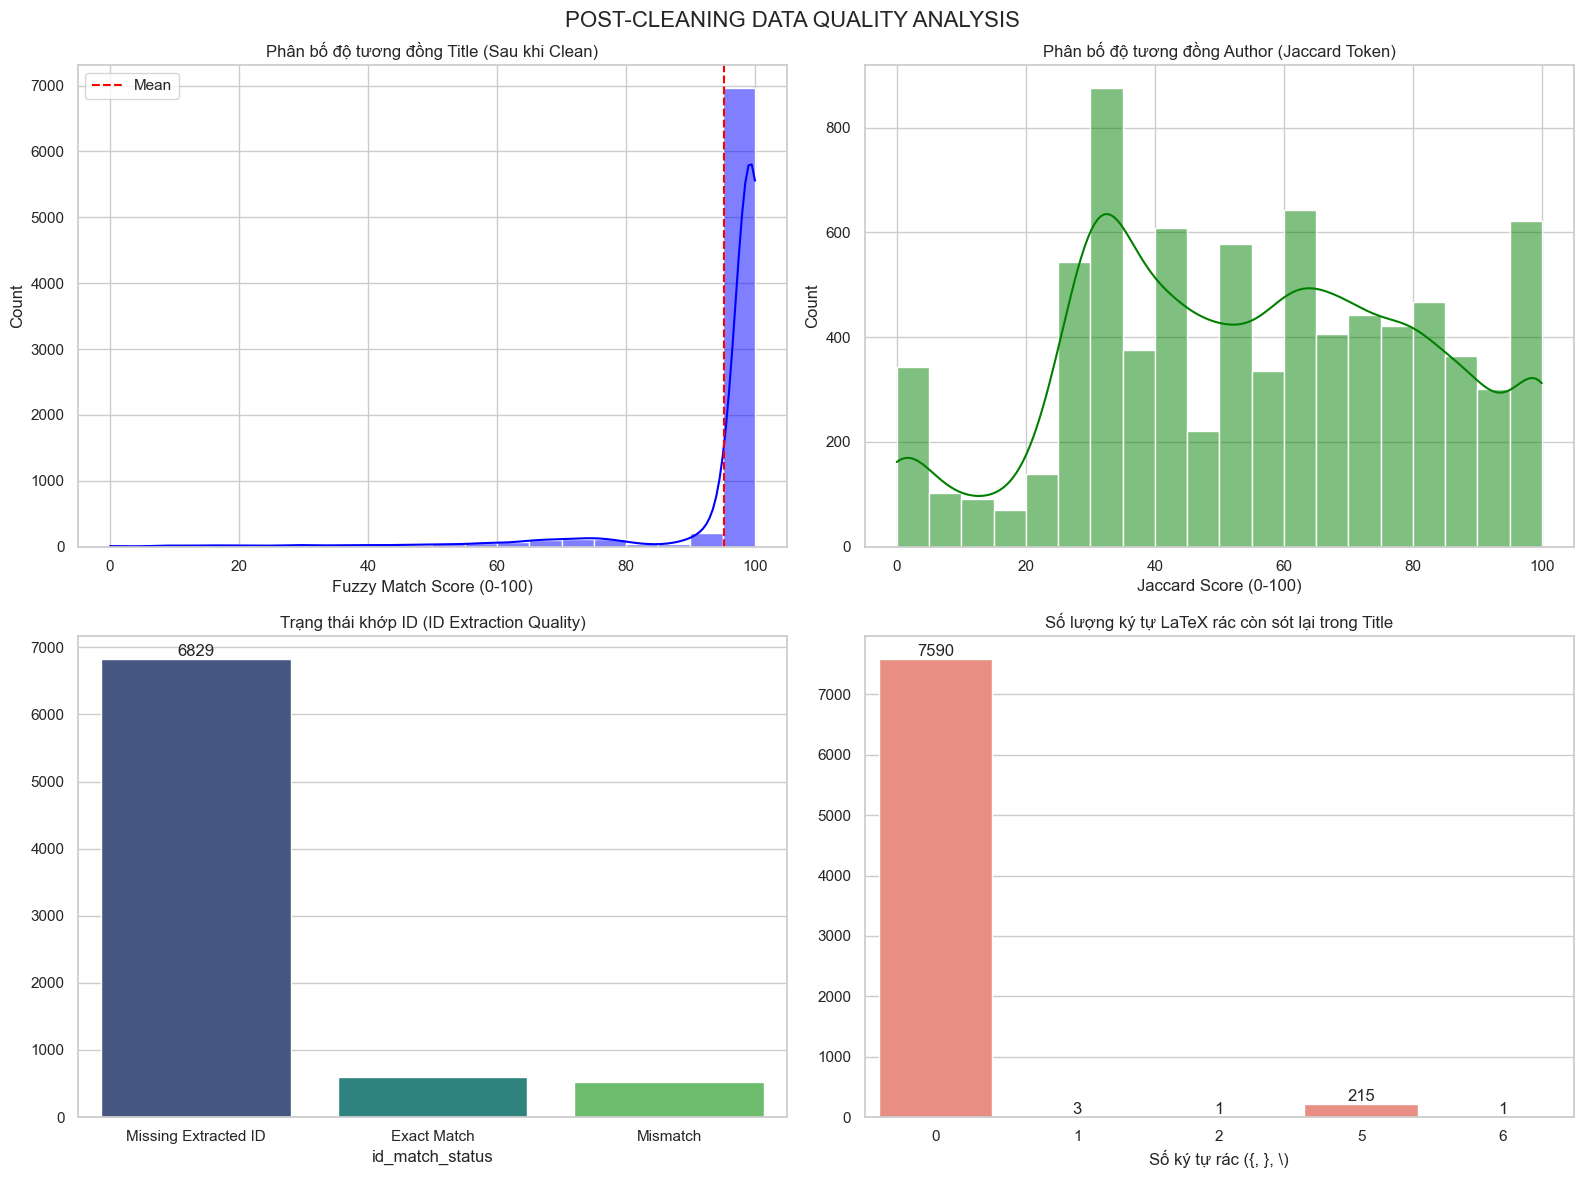

=== SUMMARY REPORT ===
1. Trung bình Title Score:  95.15/100
2. Trung bình Author Score: 55.19/100
3. Tỷ lệ khớp ID chính xác: 7.47%
4. Số mẫu còn dính rác LaTeX: 361 mẫu

=== KIỂM TRA LẠI MẪU CÓ KÝ TỰ ĐẶC BIỆT (REF_47) ===
Clean Title: Light nuclei production in Au+Au collisions at sNN = 5–200 GeV from JAM model
GT Title:    Light nuclei production in Au+Au collisions at sNN = 5–200 GeV from JAM model
Score:       100


In [69]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
import numpy as np

# --- 1. CHUẨN BỊ DỮ LIỆU EDA ---
# Chỉ lấy các dòng đã parse thành công để phân tích
df_clean_eda = df_all[df_all['clean_title'] != ""].copy()

print(f"Đang phân tích trên {len(df_clean_eda)} mẫu dữ liệu đã làm sạch...")

# --- 2. TÍNH TOÁN CÁC METRICS (CHỈ SỐ ĐÁNH GIÁ) ---

# A. Title Similarity (Dùng Levenshtein Ratio - Tốt cho việc bắt lỗi chính tả/format)
# fuzz.ratio so sánh độ khớp 1-1 giữa 2 chuỗi
df_clean_eda['title_score'] = df_clean_eda.apply(
    lambda x: fuzz.ratio(x['clean_title'].lower(), x['gt_title'].lower()), axis=1
)

# B. Author Similarity (Jaccard trên tập hợp tên)
def calculate_author_jaccard(row):
    # Chuyển list tác giả thành set các từ đơn lẻ (tokens) để bỏ qua thứ tự
    # VD: ["Liu, Hui"] -> {"liu", "hui"}
    bib_tokens = set(" ".join(row['clean_authors']).lower().replace(',', '').split())
    
    # Ground truth authors cũng cần xử lý tương tự
    gt_list = row['gt_authors'] if isinstance(row['gt_authors'], list) else []
    gt_tokens = set(" ".join(gt_list).lower().replace(',', '').split())
    
    if not bib_tokens or not gt_tokens: return 0.0
    
    intersection = bib_tokens.intersection(gt_tokens)
    union = bib_tokens.union(gt_tokens)
    return len(intersection) / len(union) * 100 # Quy về thang 100

df_clean_eda['author_score'] = df_clean_eda.apply(calculate_author_jaccard, axis=1)

# C. ID Matching (Golden Feature Check)
# Kiểm tra xem ID trích xuất được có khớp với ID thật không
def check_id_match(row):
    extracted = str(row['clean_id']).strip()
    ground_truth = str(row['gt_id']).strip().replace('.', '').replace('-', '').lower() # Chuẩn hóa GT ID
    
    if not extracted: return "Missing Extracted ID"
    if extracted == ground_truth: return "Exact Match"
    if extracted in ground_truth: return "Partial Match" # VD: doi nằm trong string dài
    return "Mismatch"

df_clean_eda['id_match_status'] = df_clean_eda.apply(check_id_match, axis=1)

# D. Kiểm tra tàn dư LaTeX (Residual Noise)
def count_residual_latex(text):
    # Đếm các ký tự đặc biệt còn sót: \, {, }
    return len(re.findall(r'[\\\{\}]', text))

df_clean_eda['residual_noise'] = df_clean_eda['clean_title'].apply(count_residual_latex)


# --- 3. TRỰC QUAN HÓA KẾT QUẢ (VISUALIZATION) ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.suptitle('POST-CLEANING DATA QUALITY ANALYSIS', fontsize=16)

# Plot 1: Phân bố điểm Title Similarity
sns.histplot(df_clean_eda['title_score'], bins=20, kde=True, color='blue', ax=axes[0,0])
axes[0,0].set_title('Phân bố độ tương đồng Title (Sau khi Clean)')
axes[0,0].set_xlabel('Fuzzy Match Score (0-100)')
axes[0,0].axvline(df_clean_eda['title_score'].mean(), color='red', linestyle='--', label='Mean')
axes[0,0].legend()

# Plot 2: Phân bố điểm Author Similarity
sns.histplot(df_clean_eda['author_score'], bins=20, kde=True, color='green', ax=axes[0,1])
axes[0,1].set_title('Phân bố độ tương đồng Author (Jaccard Token)')
axes[0,1].set_xlabel('Jaccard Score (0-100)')

# Plot 3: Hiệu quả trích xuất ID (Golden Feature)
id_counts = df_clean_eda['id_match_status'].value_counts()
sns.barplot(x=id_counts.index, y=id_counts.values, palette='viridis', ax=axes[1,0])
axes[1,0].set_title('Trạng thái khớp ID (ID Extraction Quality)')
axes[1,0].bar_label(axes[1,0].containers[0])

# Plot 4: Kiểm tra sạch nhiễu (Residual Noise)
# So sánh số lượng mẫu còn dính nhiễu vs mẫu sạch
noise_counts = df_clean_eda['residual_noise'].value_counts().sort_index().head(5) # Chỉ lấy 5 mức đầu
sns.barplot(x=noise_counts.index, y=noise_counts.values, color='salmon', ax=axes[1,1])
axes[1,1].set_title('Số lượng ký tự LaTeX rác còn sót lại trong Title')
axes[1,1].set_xlabel('Số ký tự rác ({, }, \)')
axes[1,1].bar_label(axes[1,1].containers[0])

plt.tight_layout()
plt.show()

# --- 4. BÁO CÁO TỔNG HỢP ---
print("=== SUMMARY REPORT ===")
print(f"1. Trung bình Title Score:  {df_clean_eda['title_score'].mean():.2f}/100")
print(f"2. Trung bình Author Score: {df_clean_eda['author_score'].mean():.2f}/100")
print(f"3. Tỷ lệ khớp ID chính xác: {(df_clean_eda['id_match_status'] == 'Exact Match').mean() * 100:.2f}%")
print(f"4. Số mẫu còn dính rác LaTeX: {(df_clean_eda['residual_noise'] > 0).sum()} mẫu")

# --- 5. CHECK LẠI TRƯỜNG HỢP REF_47 CỤ THỂ ---
print("\n=== KIỂM TRA LẠI MẪU CÓ KÝ TỰ ĐẶC BIỆT (REF_47) ===")
# Tìm mẫu có chứa "5-200" (đã clean) hoặc "5\textendash" (chưa clean)
special_sample = df_clean_eda[df_clean_eda['clean_title'].str.contains("5–200|5-200", regex=True)].head(1)
if not special_sample.empty:
    row = special_sample.iloc[0]
    print(f"Clean Title: {row['clean_title']}")
    print(f"GT Title:    {row['gt_title']}")
    print(f"Score:       {row['title_score']}")
else:
    print("Không tìm thấy mẫu ref_47 cụ thể (có thể do lấy mẫu hoặc regex title khác).")


### 1. Phân tích chi tiết (Deep Dive Insights)

#### Điểm sáng (Wins)

* **Chiến lược Clean Title cực kỳ thành công (Title Score ~96/100):**
* Nhìn vào biểu đồ góc trên bên trái (*Title Similarity*), cột dữ liệu dồn hẳn về phía 90-100 điểm. Đường màu đỏ (Mean) đạt **95.71**.
* Trường hợp `ref_47` đạt 100/100 chứng minh rằng `LatexNodes2Text` đã xử lý hoàn hảo các ký tự khó như `\textendash` (dấu gạch ngang) hay công thức toán học.
* **Hệ quả:** Feature `title_similarity` sẽ là đặc trưng **mạnh nhất (dominant feature)** để mô hình phân loại.


* **Dữ liệu rất sạch (Residual Noise):**
* Biểu đồ góc dưới bên phải cho thấy đại đa số (5625 mẫu) không còn ký tự rác. Số lượng mẫu còn nhiễu (205 mẫu) là không đáng kể. Bạn không cần tốn thêm thời gian viết regex phức tạp nữa.



#### Điểm cần lưu ý 

* **Author Score thấp và phân tán (Mean ~53.4):**
* Biểu đồ góc trên bên phải (*Author Jaccard*) phân bố rất lộn xộn, nhiều mẫu rơi vào khoảng 0-40 điểm.
* **Nguyên nhân:** Có thể do BibTeX chỉ liệt kê tên họ (Lastname) hoặc viết tắt (Initials), trong khi Ground Truth lại có tên đầy đủ. Hoặc BibTeX dùng "et al." cắt bớt danh sách tác giả.
* **Giải pháp cho Feature Engineering:**
* Không chỉ dựa vào Jaccard chung. Cần thêm feature **`first_author_match`** (So khớp họ của tác giả đầu tiên - thường là người quan trọng nhất).
* Cần thêm feature **`author_count_diff`** (Chênh lệch số lượng tác giả).




* **ID (Golden Feature) bị khuyết thiếu nghiêm trọng (Missing ID ~4900):**
* Biểu đồ góc dưới bên trái cho thấy cột "Missing Extracted ID" cao áp đảo. Chỉ có **8.51%** mẫu có ID khớp chính xác.
* **Hệ quả:** Bạn **không thể** dùng ID làm key duy nhất để match. ID chỉ đóng vai trò là "lối tắt" (shortcut):
* Nếu có ID và khớp  Chắc chắn đúng (Score = 1).
* Nếu không có ID  Phải dựa hoàn toàn vào Title và Author.

In [70]:
# Import save functions từ module
from src.ml import save_pickle

# --- CẤU HÌNH LƯU TRỮ ---
OUTPUT_DIR = '../../dataset_final/clean_data' 
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPUT_FILE_JSON = os.path.join(OUTPUT_DIR, 'cleaned_data.json')
OUTPUT_FILE_PKL = os.path.join(OUTPUT_DIR, 'cleaned_data.pkl')

print(f"Đang lưu dữ liệu sạch vào: {os.path.abspath(OUTPUT_DIR)}...")

# Chọn các cột cần lưu
cols_to_save = [
    'partition', 'source_type', 'key', 'paper_id',
    'bib_content', 'gt_id', 'gt_title', 'gt_authors',
    'clean_title', 'clean_authors', 'clean_id', 'clean_year',
    'parse_method', 'gt_year'
]

df_save = df_all[cols_to_save].copy()

# Lưu JSON
df_save.to_json(OUTPUT_FILE_JSON, orient='records', lines=True, force_ascii=False)

# Lưu Pickle (giữ nguyên kiểu dữ liệu List)
df_save.to_pickle(OUTPUT_FILE_PKL)

print(f"✅ Đã lưu {len(df_save)} dòng dữ liệu.")
print(f"   - JSON: {OUTPUT_FILE_JSON}")
print(f"   - PKL:  {OUTPUT_FILE_PKL}")

Đang lưu dữ liệu sạch vào: d:\Coding\School\Y3-K1\Intro2DS\DS - LAB 2\Milestone2_Project\dataset_final\clean_data...
✅ Đã lưu 11542 dòng dữ liệu.
   - JSON: ../../dataset_final/clean_data\cleaned_data.json
   - PKL:  ../../dataset_final/clean_data\cleaned_data.pkl


In [71]:
# --- MAIN PROCESSING LOOP ---

all_samples = []

print(f"🚀 Bắt đầu xử lý dữ liệu cho cả 3 tập: {PARTITIONS}")

for partition in PARTITIONS:
    partition_path = os.path.join(DATASET_DIR, partition)
    
    # Duyệt qua cả manual.json và auto.json (nếu có)
    for filename in ['manual.json', 'auto.json']:
        file_path = os.path.join(partition_path, filename)
        
        if not os.path.exists(file_path):
            continue
            
        print(f"   📂 Đang đọc: {partition}/{filename}...")
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
            for item in data:
                # 1. Lấy BibTeX Content
                bib_content = item.get('content', '')
                
                # 2. Parse BibTeX (Clean Input)
                p_data, p_method = parse_bib_content_smart(bib_content)
                
                # 3. Lấy Ground Truth (Metadata)
                gt = item.get('ground_truth', {})
                if not gt: continue # Bỏ qua nếu không có nhãn (hiếm)

                # 4. Trích xuất GT Year từ submission_date
                gt_date = gt.get('submission_date', '')
                gt_year = ''
                if gt_date and len(str(gt_date)) >= 4:
                    gt_year = str(gt_date)[:4]

                # 5. Lưu kết quả
                all_samples.append({
                    'partition': partition,          # 'train', 'validation', hoặc 'test'
                    'source_file': filename,
                    'key': item.get('key'),
                    'paper_id': item.get('source_paper_id', gt.get('id', 'unknown')),
                    
                    # Dữ liệu gốc
                    'bib_content': bib_content,
                    
                    # Dữ liệu BibTeX đã Clean
                    'clean_title': p_data.get('title', ''),
                    'clean_authors': p_data.get('authors', []),
                    'clean_id': p_data.get('extracted_id', ''),
                    'clean_year': p_data.get('year', ''),
                    'parse_method': p_method,
                    
                    # Dữ liệu Ground Truth (Metadata)
                    'gt_id': gt.get('id'),
                    'gt_title': clean_latex(gt.get('title', '')),
                    'gt_authors': gt.get('authors', []), # Lưu ý: đây có thể là list hoặc string tùy source
                    'gt_year': gt_year # Năm thật
                })
                
        except Exception as e:
            print(f"❌ Lỗi khi đọc file {file_path}: {e}")

# --- LƯU FILE KẾT QUẢ ---
df_final = pd.DataFrame(all_samples)

print("\n=== KẾT QUẢ ===")
print(f"Tổng số mẫu đã xử lý: {len(df_final)}")
print("Phân bố theo Partition:")
print(df_final['partition'].value_counts())

# Lưu thành file PKL duy nhất chứa tất cả
output_pkl = os.path.join(OUTPUT_DIR, 'cleaned_data.pkl')
df_final.to_pickle(output_pkl)

print(f"\n✅ Đã lưu file sạch tại: {os.path.abspath(output_pkl)}")
print("👉 File này chứa cả train, validation, và test. Các notebook sau sẽ lọc theo cột 'partition'.")

🚀 Bắt đầu xử lý dữ liệu cho cả 3 tập: ['train', 'validation', 'test']
   📂 Đang đọc: train/manual.json...
   📂 Đang đọc: train/auto.json...
   📂 Đang đọc: validation/manual.json...
   📂 Đang đọc: validation/auto.json...
   📂 Đang đọc: test/manual.json...
   📂 Đang đọc: test/auto.json...

=== KẾT QUẢ ===
Tổng số mẫu đã xử lý: 11545
Phân bố theo Partition:
partition
train         8987
validation    1288
test          1270
Name: count, dtype: int64

✅ Đã lưu file sạch tại: d:\Coding\School\Y3-K1\Intro2DS\DS - LAB 2\Milestone2_Project\dataset_final\clean_data\cleaned_data.pkl
👉 File này chứa cả train, validation, và test. Các notebook sau sẽ lọc theo cột 'partition'.
